# Spectrogram Plotting
This notebook has code for computing & plotting of spectrogram and  corresponding waveform / segmentation

### Dependencies
This example notebook does the plotting directly in matplotlib and has a minimum of other dependencies   
+ librosa is used for the spectrogram computations
+ soundfile is used for importing audiofiles
+ examples are given for importing data from url resources
+ the notebook has been tested in Python 3.6 and 3.8 on Google Colab and win10 platforms
+ Date: 11/11/2020

## IMPORTS


In [1]:
import os,sys,io 
import scipy.signal

from urllib.request import urlopen
from IPython.display import display, Audio, HTML

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
%matplotlib inline

import librosa as librosa

try:
  import google.colab
  IN_COLAB = True
  ! pip -q install soundfile
except:
  IN_COLAB = False
import soundfile as sf



## MAIN ROUTINES
> spg = spectrogram(y)  
> fig = spg_plot(spg,wav,seg,...)

In [2]:
import math
scale=10.0/math.log(10)
DB_EPSILON_KALDI = -69.23689    # scale*math.log(1.19209290e-7)  default flooring applied in KALDI
EPSILON_FLOAT = 1.19209290e-7

# routine for reading audio from different inputs
def read_audio_from_url(url):
  fp = io.BytesIO(urlopen(url).read())
  data, sr = sf.read(fp,dtype='float32')
  return(data,sr)

# time to index converstions;  inputs can be scalars, lists or numpy arrays  outputs are always numpy arrays
def t2indx(t,sr):
  return (np.array(t).astype(float)*float(sr)+0.5).astype(int)
def indx2t(i,sr):
  return np.array(i).astype(float)/float(sr)

# prep: perpare your samples; extend the edges n_pad samples (mode=reflection) on both sides and do preemphasis    
def edges_and_preemp_(y,preemp=0.97,edges='Kaldi',n_fft=512,nshift=160,nlength=400):
    if (edges == 'Kaldi') | (edges == 'SPRAAK'):
        i1 = nshift//2
        i2 = nshift//2
        n_pad = n_fft//2
    elif edges == 'librosa':
        i1 = 0
        i2 = 0
        n_pad = n_fft//2
    elif edges ==  'HTK':
        n_pad = 0
        i1 = 0
        i2 = 0
    z=np.concatenate((y[0:n_pad][::-1],y,y[:-n_pad-1:-1]))
    z[0]=(1.-preemp)*y[0]
    z[1:]= z[1:] - preemp*z[0:-1]
    return(z[i1:len(z)-i2])
    
def spectrogram(y,sr=16000,frame_shift=10.,frame_length=30.,preemp=0.97,n_mels=80,n_fft=512,window='hamm',
                output='dB',amin=EPSILON_FLOAT,edges='Kaldi'):
    '''
    spectrogram computes spectrogram or filterbank features
        it makes use of the librosa library for the underlying calls
        it has a number of small variants in way edges are treated (Kaldi/SPRAAK, librosa, HTK)

    required arguments:
      y       waveform data (numpy array) 

    optional arguments:
      sr           sample rate, default=16000
      frame_shift  frame shift in msecs, default= 10.0 msecs
      frame_length frame length in msecs, default= 30.0 msecs
      preemp       preemphasis coefficient, default=0.95
      window       window type, default='hamm'
      n_mels       number of mel channels, default=80
      n_fft        number of fft coefficients, default=512
      output       output scale, default='dB', options['dB','power']
      amin         flooring applied to power before conversion to dB (default= KALDI EPSILON)
      edges        string ('Kaldi', 'librosa', 'HTK', 'SPRAAK')  default='Kaldi'      

    output:
      mel spectrogram
      !! if n_mel==None, the magnitude spectrogram will be returned

    Notes on frame positioning / snipping of the edges:
    (whenever applicable edge reflection is done before preemphasis)
    
    edges = 'Kaldi' | 'SPRAAK'   [best for alignment with continuous time data]
          number of frames = len(y) // nshift
          data is reflected at the edges and 
          frames are centered at y[frame*hop_length + hop_length/2] 
    edges = 'librosa'
          number of frames = (len(y) ) // nshift + 1
          frames are centered at y[frame*hop_length] 
          this corresponds to the default librosa settings with center=True
    edges = 'HTK'
            HTK puts all frames 100% within the original data (this is not an exact implementation but close)
            number of frames = (len(y) - nlength + nshift) // nshift
          
    '''

    nshift = int(float(sr)*frame_shift/1000.0)
    nlength = int(float(sr)*frame_length/1000.0)
    
    y_pre = edges_and_preemp_(y,preemp=preemp,edges=edges,n_fft=n_fft,nshift=nshift,nlength=nlength)    
    spg_stft = librosa.stft(y_pre,n_fft=n_fft,hop_length=nshift,win_length=nlength,window=window,center=False)
    spg_power = np.abs(spg_stft)**2
    if n_mels == None:
      spg = spg_power
    else:
      spg = librosa.feature.melspectrogram(S=spg_power,n_mels=n_mels,sr=sr)

    if output== 'dB':
        return(librosa.power_to_db(spg,amin=amin))
    else:
        return(spg)

In [3]:
# spectrogram plotting in matplotlib
#     with alignment between waveform, spectrogram(s) and segmentation(s)
#
def plot_spg(spg=None,wav=None,seg=None,txt=None,figsize=(12,8),spg_scale=2,sr=16000,n_shift=160):
    '''plot_spg(): Spectrogram plotting routine
            screen will be built of 3 parts
            TOP:     waveform data (optional) + optional word transcriptions
            MIDDLE:  spectrogram data (at least one required)
            BOTTOM:  segmentations (optional)
    
        fig         figure handle for the plot
        spg         spectrogram (list or singleton) data (required), numpy array [n_param, n_fr] 
        wav         waveform data (optional)
        seg         segmentation (list, singleton or none) plotted in segmentation window at the bottom
                    should be passed as DataFrame, optional
        txt         full segment transcript to be printed in waveform axis
        figsize     figure size (default = (12,8))
        spg_scale   vertical scale of spectrogram wrt wav or seg  (default=2)
        sr          sampling rate (default=16000)
        n_shift     frame shift in samples, or equivalently the width of non-overlapping frames
                      this is used for synchronisation between waveform and spectrogram/segmentations

        Edges explained:
          spg(n_param,n_fr)    
                  x-range   0 ... nfr-1
                  x-view  [-0.5 , nfr-0.5 ]    extends with +- 0.5
          wavdata(n_samples)
                  x-range   0 ... wavdata
                  x-view    -n_shift/2   nfr*n-shift - n_shift/2   (all converted to timescale)
        '''

    if spg is None:
        print("plot_spg(): You must at least provide a spectrogram")
        return
    if type(spg) is not list: spg = [ spg ]
    nspg = len(spg)
    (n_param,n_fr) = spg[0].shape
    
    if seg is None:
        nseg = 0
    else:
        if type(seg) is not list: seg = [seg]
        nseg = len(seg)
        SegPlot = True       

    WavPlot = False if wav is None   else True
    TxtPlot = False if txt is None   else True
    nwav = 1        if WavPlot       else 0
    
    # make an axes grid for nwav waveform's, nspg spectrogram's, nseg segmentation's
    base_height = 1.0/(nwav+nseg/2.0+nspg*spg_scale)
    nrows = nwav+nspg+nseg
    heights = [base_height]*nrows
    for i in range(0,nspg): heights[nwav+i] = base_height*spg_scale
    for i in range(0,nseg): heights[nwav+nspg+i] = base_height/2.0
    fig = plt.figure(figsize=figsize,clear=True,constrained_layout=True)
    gs = fig.add_gridspec(nrows=nrows,ncols=1,height_ratios=heights)
    
    # frame-2-time synchronization on basis of n_fr frames in spectrogram and n_shift
    #    by default it extends the view at the edges by  1/2 nshift samples
    indxlimits = np.array([-n_shift/2, n_fr*n_shift-n_shift/2])
    tlimits = indx2t(indxlimits,sr)  

    # add waverform plot
    if WavPlot:
        ax = fig.add_subplot(gs[0,0])
        n_samples = len(wavdata)
        if n_samples <= ((n_fr-1) * n_shift):
            print("plot_spg() WARNING: waveform too short for spectrogram: %d <= (%d-1) x %d" %
                  (n_samples, n_fr,n_shift))
        wavtime = np.linspace(0.0, indx2t(n_samples,sr), n_samples)
        fshift = indx2t(n_shift,sr)
        ax.plot(wavtime,wavdata)
        wmax = 1.2 * max(abs(wavdata))
        ax.set_ylim(-wmax,wmax)
        ax.set_xlim(tlimits)

        ax.tick_params(axis='x',labeltop=True,top=True,labelbottom=False,bottom=False)
        if TxtPlot:
            ax.text(tlimits[1]/2.,0.66*wmax,txt,fontsize=16,horizontalalignment='center')  

    # add spectrograms
    for i in range(0,nspg):
        ax = fig.add_subplot(gs[nwav+i,0])
        ax.imshow(spg[i],cmap='jet',aspect='auto',origin='lower')
        ax.tick_params(axis='x',labelrotation=0.0,labelbottom=False,bottom=True)        
        if (i == nspg-1) & (nseg==0):
            ax.tick_params(axis='x',labelbottom=True)

    # add segmentations
    for i in range(0,nseg):
        ax = fig.add_subplot(gs[nwav+nspg+i,0])
        plot_seg(ax,seg[i],xlim=tlimits,ytxt=0.5,linestyle='dashed',fontsize=10)
        if i != nseg-1:
            ax.tick_params(axis='x',labelbottom=False)

#        plot_seg(ax,seg1,ymin=0.5,ymax=1.0,ytxt=0.75,linestyle='dashed',fontsize=10)
#        plot_seg(ax_seg,seg2,ymin=0.,ymax=0.5,ytxt=0.25,linecolor='r')
        
    return(fig)

# routine for plotting the segmentations   
def plot_seg(ax,df,xlim=[0.,1.],ytxt=0.5,linestyle='solid',linecolor='k',fontsize=14,Vlines=True):
    ''' plot_seg(): plots a segmentation to an axis

    ax:   axis
    df:   dataframe with segment data

    xlim:       X-axis range (default: [0 1])
    [ ymin, ymax: Y-axis range (default: [0 1]) ]
    ytxt        height at which to write out the segmentation (default= 0.5)
    Vlines      flag for plotting segmentation lines (default=True)
    linestyle   default='solid'
    linecolor   default='k'
    fontsize    default=14
    ''' 

    # First plot a dummy axis to avoid matplotlib going wild
    ax.imshow(np.zeros((1,1)),aspect='auto',cmap='Greys',vmin=0.,vmax=1) 
    for iseg in range(0,len(df)):
        i1= df['t0'][iseg]
        i2= df['t1'][iseg]
        txt = df['seg'][iseg]
        if(Vlines):
            ax.vlines([i1,i2],0.,1.,linestyles=linestyle,colors=linecolor)
        xtxt = float(i1+(i2-i1)/2.0)
        ax.text(xtxt,ytxt,txt,fontsize=fontsize,horizontalalignment='center')  
        
    ax.tick_params(axis='y',labelleft=False,left=False)
    ax.set_ylim([0.,1.])
    ax.set_xlim(xlim)

## DATA LOADING
- sampled data, reads waveform and sampling rate
- segmentations
  + TIMIT style segmentations are stored in a dataframe with columns ['t0','t1','seg']

In [4]:
dir='https://raw.githubusercontent.com/compi1234/spchlab/master/data/'
wavfile = "timit/si1027.wav" #@param {type:"string"}
sent_segmentation = "timit/si1027.txt" #@param {type:"string"}
word_segmentation = "timit/si1027.wrd" #@param {type:"string"}
phone_segmentation = "timit/si1027.phn" #@param {type:"string"}
word_segmentation = "timit/si1027.wrd" #@param {type:"string"}
phone_mapping = "timit/phones-61-48-39.txt" #@param {type:"string"}

# read the datafiles
wavdata, sr = read_audio_from_url(dir+wavfile)
transcript = io.StringIO(urlopen(dir+sent_segmentation).read().decode('utf-8')).readline().strip().split(None,2)[2]
segwrd = pd.read_csv(dir+word_segmentation,delim_whitespace=True,names=['t0','t1','seg'])
segphn = pd.read_csv(dir+phone_segmentation,delim_whitespace=True,names=['t0','t1','seg'])

# convert sample based segmentations to time based segmentations
segphn['t0']=indx2t(segphn['t0'],sr)
segphn['t1']=indx2t(segphn['t1'],sr)
segwrd['t0']=indx2t(segwrd['t0'],sr)
segwrd['t1']=indx2t(segwrd['t1'],sr)

# convert TIMIT61 to TIMIT39
# this routine is not great as it simply maps closures to silence instead to combining
phone_tbl = pd.read_csv(dir+phone_mapping,delim_whitespace=True,names=['T61','T48','T39'])
map61_39 = dict(zip(phone_tbl['T61'],phone_tbl['T39']))
segphn39 = segphn.replace({"seg": map61_39})

## Compute Spectrograms and Plot them

In [5]:
# compute a standard spectrogram and a 80 and 24 channel mel filterbank
spg = spectrogram(wavdata,sr=sr,n_mels=None)
spg80 = spectrogram(wavdata,sr=sr,n_mels=80)
spg24 = spectrogram(wavdata,sr=sr,n_mels=24)

Text(0, 0.5, 'mel fbank(24)')

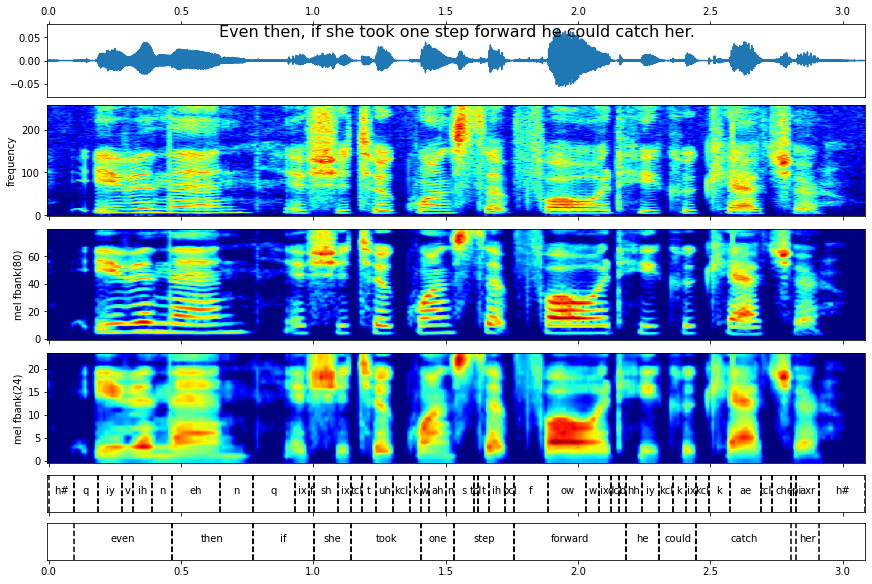

In [12]:
# display audio button and the spectrograms ; add additional lables
display(Audio(data=wavdata,rate=sr))
fig=plot_spg(spg=[spg,spg80,spg24], wav=wavdata, seg=[segphn,segwrd],txt=transcript,figsize=(12,8),spg_scale=1.5)
ax = fig.get_axes()
ax[1].set_ylabel('frequency')
ax[2].set_ylabel('mel fbank(80)')
ax[3].set_ylabel('mel fbank(24)')

In [8]:
# the code below higlight the (minor) differences due to different settings of the 'edges' option
# default librosa edges have offset wavdata by -n_shift//2 samples wrt. the Kaldi/SPRAAK way
#    you can compensate for this by shifting the input by n_shift//2 samples but this effects which samples are included at the boudaries 
#    hence spg1 and spg2 are identical except for first and last frame
# with HTK edges you normally have a few frames less in the final file
spg1 = spectrogram(wavdata,sr=sr,edges='Kaldi', n_mels=None)
spg2 = spectrogram(wavdata[80:],sr=sr,edges='librosa', n_mels=None)
spg3 = spectrogram(wavdata,sr=sr,edges='HTK', n_mels=None)
spg1.shape,spg2.shape,spg3.shape

((257, 309), (257, 309), (257, 306))

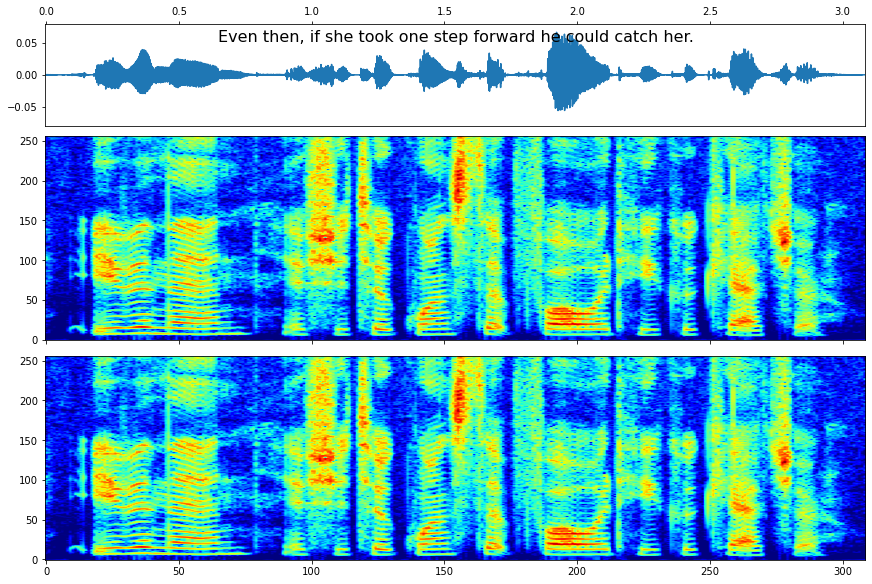

In [10]:
f1 = plot_spg(spg=[spg1,spg2],wav=wavdata,txt=transcript)